## Homework 4: due 2024/05/14 23:59 (100%)

### - Tutorial : 

1. Transfer Learning for Computer Vision Tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
2. Torchvision transforms: https://pytorch.org/vision/stable/transforms.html
3. Torchvision models: https://pytorch.org/vision/stable/models.html
4. Pytorch learning rate scheduler: https://pytorch.org/docs/stable/optim.html
5. How to get learning rate: https://stackoverflow.com/questions/52660985/pytorch-how-to-get-learning-rate-during-training
6. Pytorch tutorials: https://pytorch.org/tutorials/index.html#

### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.



#### You will train a multi-class classification model in this part. The data contains the images with three categories: cats, dogs and pandas. You can find the details of each column at https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import os
import random
import time
import glob

from tqdm import tqdm

cudnn.benchmark = True
plt.ion()   # interactive mode

In [5]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [6]:
# Define the device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cuda:0


### 1. Define the model and dataset (20%)

#### 1.1 Please create the train/validation dataloaders with the data from the __animals__ folder. You can use the function from __torchvision.datasets.ImageFolder__ to load the data. In the training dataset, you should resize the images to 224x224, randomly horizontal flip the images, and normalize the images with mean [0.485, 0.456, 0.406] and standard deviation [0.229, 0.224, 0.225]. As for the validation dataset, do the same transfromation with the training dataset but without flipping the images.(15%)


##### (Note. The default batch size is 4; however, if your hardware can not afford the computation, you can decrease the batch size.)

In [27]:
#set the batch size
batch_size = 4

#Data path
trainPath = 'animals/train/'
valPath = 'animals/val/'
testPath = 'animals/test/'
predictPath = 'animals/prediction'

#Data transformation

data_transforms_dict = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'val': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'test': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'prediction': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
}

#load data
image_datasets = {x: datasets.ImageFolder(os.path.join('animals', x), data_transforms_dict[x]) 
                  for x in ['train', 'val', 'test']}

#Dataloader
loaders_scratch = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
    for x in ['train', 'val', 'test']
}




### 1.2 Use the function __imshow__ to show the samples of dataset. (5%)

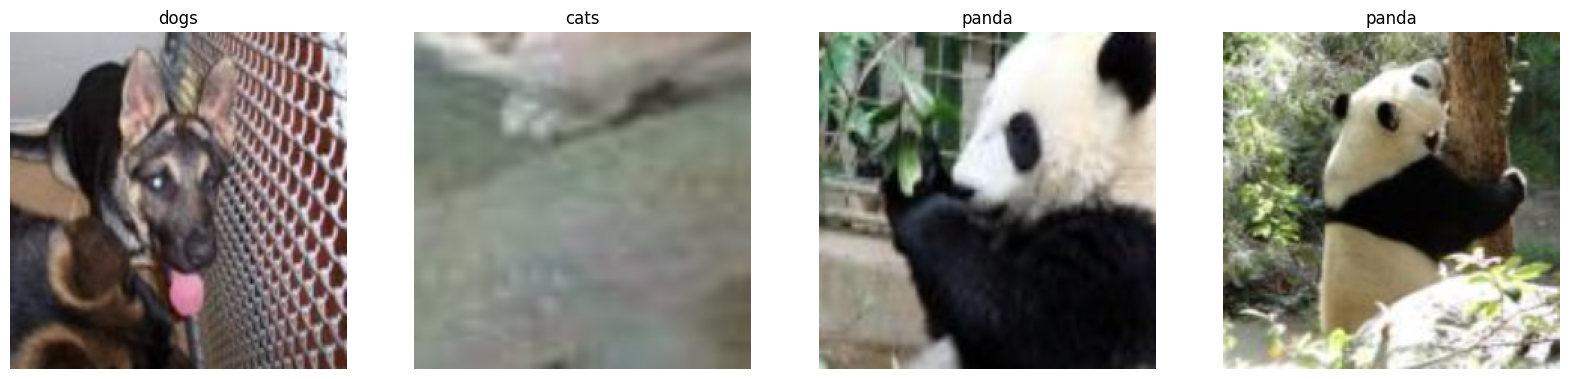

In [28]:
# Get a batch of training data
inputs, classes = next(iter(loaders_scratch['train']))
classes_names = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

num_images = len(inputs)  # 获取图像数量
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))  # 创建一个 subplot 行，每个图像一个 subplot

for i, (image, label) in enumerate(zip(inputs, classes)):
    image = image.to("cpu").clone().detach()  # 将图像移动到 CPU
    image = image.numpy().squeeze()  # 转换为 NumPy 数组并去掉不必要的维度
    image = image.transpose(1, 2, 0)  # 转置维度以适应 matplotlib 的显示格式
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))  # 反归一化
    image = image.clip(0, 1)  # 限制图像值在 0 到 1 之间

    ax = axes[i] if num_images > 1 else axes  # 获取当前 subplot 的轴对象
    ax.imshow(image)  # 在当前轴上显示图像
    ax.set_title(classes_names[label])  # 设置标题为类别名称
    ax.axis('off')  # 关闭坐标轴显示

plt.show()  # 显示整个图形

### 2. Train the model (80%)

#### 2.1 Define a function called __train_model__ to train the model and record the loss/accuracy/learning rate/time by adapting the codes from the tutorial. Also, save the model with the best accuracy score on the validation dataset. (15%)


In [27]:
#for apple silicon device, RUN this code
use_mps = torch.backends.mps.is_available()
use_cuda = torch.cuda.is_available()
if use_mps:
    device = torch.device("mps")
    print(device, "is available")
elif use_cuda:
    device = torch.device("cuda")
    print(device, "is available")
else:
    device = torch.device("cpu")
    print(device, "is available")
#remember to  check if your data and model is in the same device

cuda is available


In [26]:
try:
    ImageFile.LOAD_TRUNCATED_IMAGES = True
except:
    pass


def train_model(n_epochs, loaders, model, optimizer, scheduler, criterion, device, save_path):

    scheduler = scheduler
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []
    learning_rate_history = []

    best_acc = 0.0
    for epoch in range(1, n_epochs + 1):
        print('-' * 10)
        print(f'Epoch {epoch }/{n_epochs}')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            #iterate over data
            for data, target in loaders[phase]:
                data, target = data.to(device), target.to(device)
                #zero the parameter gradients
                optimizer.zero_grad()

                #forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(data)
                    loss = criterion(output, target)
                    _, preds = torch.max(output, 1)
                    #backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                #statistics
                running_loss += loss.item() * data.size(0)
                running_corrects += torch.sum(preds == target.data)

            if phase == 'train':
                scheduler.step()
            # epoch_loss = np.mean(running_loss)
            # epoch_acc = np.mean(running_corrects)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss = epoch_loss
                train_acc = epoch_acc.cpu().numpy()
            else:
                valid_loss = epoch_loss
                valid_acc = epoch_acc.cpu().numpy()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print("Current learning rate; ", optimizer.param_groups[0]['lr'])

        
        #save the model if validation loss has decreased
        if phase == 'val' and epoch_acc >= best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), save_path)
        
        
                    
        # Append histories after converting to normal Python types or ensuring they are on CPU
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_acc_history.append(train_acc)
        valid_acc_history.append(valid_acc)
        learning_rate_history.append(optimizer.param_groups[0]['lr'])

    #save the model_metrics    
    model_metrics = {
        'train_loss_history': train_loss_history,
        'valid_loss_history': valid_loss_history,
        'train_acc_history': train_acc_history,
        'valid_acc_history': valid_acc_history,
        'learning_rate_history': learning_rate_history
    }
    return model, model_metrics


#### 2.2 Please define three models based on ResNet18 to train the networks (1) from scratch (2) by fine-tuning (3) by a fixed feature extractor. The final fully-connected layer(a single linear layer) should be adpted to fulfill this task. (15%)
##### (Note. The ResNet model can be called from the torchvision.model)
##### (Mote. The pretrained model should be trained with ImageNet dataset)


In [10]:
#create a model
#model_1 (resnet18 from scratch)
def initialize_model_from_scratch(num_classes):
    model = models.resnet18(weights = None)  # No pretrained weights
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)  # Replace the fully connected layer
    return model.to(device)
    

def initialize_model_fine_tuning(num_classes):
    model = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)  # Load pretrained weights
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)  # Replace the fully connected layer
    return model.to(device)
    
    
def initialize_model_fixed_features(num_classes):
    model = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)  # Load pretrained weights
    # Freeze all the layers in the network
    for param in model.parameters():
        param.requires_grad = False
        
    # Replace the last fully connected layer
    # Parameters of newly constructed modules have requires_grad=True by default
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)  # Only this layer is trained
    return model.to(device)


# num_classes = 10  # Example: 10 classes
# model_scratch = initialize_model_from_scratch(num_classes)
# model_finetuning = initialize_model_fine_tuning(num_classes)
# model_fixed_features = initialize_model_fixed_features(num_classes)


#### 2.3 Train three models with the same hyperpameters below and do the validation every epoch. Choose the appropriate type of loss according to the task. Also, use the learning rate scheduler to reduce the learning rate with ratio of 0.1 every 10 epoch. (20%)

#####  (Named the best checkpoints with __resnet_scratch.pth/resnet_finetune.pth/resnet_fixed_extractor.pth__)


| | Learning rate | epochs | optimizer | weight decay | momentum |
|:---:|:---:|:---:|:---:|:---:|:---:|
|***Hyperparameter***| 5e-3 | 50 | SGD | 1e-2 | 0.9 |

In [11]:
num_classes = 3  # Example: 10 classes
epoch = 50

model_scratch = initialize_model_from_scratch(num_classes)
model_finetuning = initialize_model_fine_tuning(num_classes)
model_fixed_features = initialize_model_fixed_features(num_classes)


In [32]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_scratch.parameters(), lr = 5e-3, weight_decay=1e-2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


# Train the model
print("Start Training model from scratch")
model_scratch, metric_scratch = train_model(epoch, loaders_scratch, model_scratch, optimizer, scheduler, criterion, device, 'model_scratch.pt')

Start Training model from scratch
----------
Epoch 1/50
train Loss: 1.2177 Acc: 0.4506
val Loss: 1.1212 Acc: 0.4479
Current learning rate;  0.005
----------
Epoch 2/50
train Loss: 1.0063 Acc: 0.4867
val Loss: 0.8297 Acc: 0.5531
Current learning rate;  0.005
----------
Epoch 3/50
train Loss: 0.9489 Acc: 0.5044
val Loss: 1.0741 Acc: 0.4854
Current learning rate;  0.005
----------
Epoch 4/50
train Loss: 0.9187 Acc: 0.5156
val Loss: 0.8867 Acc: 0.5302
Current learning rate;  0.005
----------
Epoch 5/50
train Loss: 0.9005 Acc: 0.5389
val Loss: 0.8017 Acc: 0.5656
Current learning rate;  0.005
----------
Epoch 6/50
train Loss: 0.9081 Acc: 0.5261
val Loss: 0.8474 Acc: 0.5563
Current learning rate;  0.005
----------
Epoch 7/50
train Loss: 0.8914 Acc: 0.5289
val Loss: 0.8447 Acc: 0.5531
Current learning rate;  0.005
----------
Epoch 8/50
train Loss: 0.8930 Acc: 0.5261
val Loss: 0.8541 Acc: 0.5479
Current learning rate;  0.005
----------
Epoch 9/50
train Loss: 0.8908 Acc: 0.5372
val Loss: 0.8011 

In [37]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_finetuning.parameters(), lr = 5e-3, weight_decay=1e-2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

print("Start Training model from fine-tuning")
model_finetuning, metric_finetuneing = train_model(epoch, loaders_scratch, model_finetuning, optimizer, scheduler, criterion, device, 'model_finetuning.pt')

Start Training model from fine-tuning
----------
Epoch 1/50
train Loss: 1.9685 Acc: 0.4056
val Loss: 1.1136 Acc: 0.5135
Current learning rate;  0.005
----------
Epoch 2/50
train Loss: 1.1836 Acc: 0.4700
val Loss: 1.1038 Acc: 0.5010
Current learning rate;  0.005
----------
Epoch 3/50
train Loss: 1.0727 Acc: 0.4783
val Loss: 0.9178 Acc: 0.5292
Current learning rate;  0.005
----------
Epoch 4/50
train Loss: 0.9623 Acc: 0.5033
val Loss: 0.8295 Acc: 0.5552
Current learning rate;  0.005
----------
Epoch 5/50
train Loss: 0.9321 Acc: 0.5072
val Loss: 0.8805 Acc: 0.5437
Current learning rate;  0.005
----------
Epoch 6/50
train Loss: 0.9282 Acc: 0.4933
val Loss: 0.9822 Acc: 0.4708
Current learning rate;  0.005
----------
Epoch 7/50
train Loss: 0.9055 Acc: 0.5267
val Loss: 0.8568 Acc: 0.5510
Current learning rate;  0.005
----------
Epoch 8/50
train Loss: 0.9058 Acc: 0.5278
val Loss: 0.9452 Acc: 0.5031
Current learning rate;  0.005
----------
Epoch 9/50
train Loss: 0.9085 Acc: 0.5328
val Loss: 0.9

In [39]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_fixed_features.parameters(), lr = 5e-3, weight_decay=1e-2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

print("Start Training model from fixed features")
model_fixed_features, metric_fixed_features = train_model(epoch, loaders_scratch, model_fixed_features, optimizer, scheduler, criterion, device, 'model_fixed_features.pt')

Start Training model from fixed features
----------
Epoch 1/50
train Loss: 1.6278 Acc: 0.6556
val Loss: 1.2401 Acc: 0.7698
Current learning rate;  0.005
----------
Epoch 2/50
train Loss: 1.5989 Acc: 0.7117
val Loss: 0.4817 Acc: 0.8760
Current learning rate;  0.005
----------
Epoch 3/50
train Loss: 1.6184 Acc: 0.7144
val Loss: 1.4667 Acc: 0.7542
Current learning rate;  0.005
----------
Epoch 4/50
train Loss: 1.5738 Acc: 0.7144
val Loss: 0.5311 Acc: 0.8771
Current learning rate;  0.005
----------
Epoch 5/50
train Loss: 1.6105 Acc: 0.7044
val Loss: 0.7119 Acc: 0.8448
Current learning rate;  0.005
----------
Epoch 6/50
train Loss: 1.8468 Acc: 0.6956
val Loss: 0.3649 Acc: 0.9021
Current learning rate;  0.005
----------
Epoch 7/50
train Loss: 2.0090 Acc: 0.7011
val Loss: 1.1967 Acc: 0.8125
Current learning rate;  0.005
----------
Epoch 8/50
train Loss: 1.7320 Acc: 0.7189
val Loss: 0.4719 Acc: 0.8875
Current learning rate;  0.005
----------
Epoch 9/50
train Loss: 1.8870 Acc: 0.6911
val Loss: 

#### 2.4 Please draw the plot the learning rate, training/validation loss and training/validation accuracy and compare the performances about three networks. (10%)
##### (Example figure)
![](https://i.imgur.com/LZZTTe6.png)
![](https://i.imgur.com/mUGTWx2.png)
![](https://i.imgur.com/KaNGIDH.png)

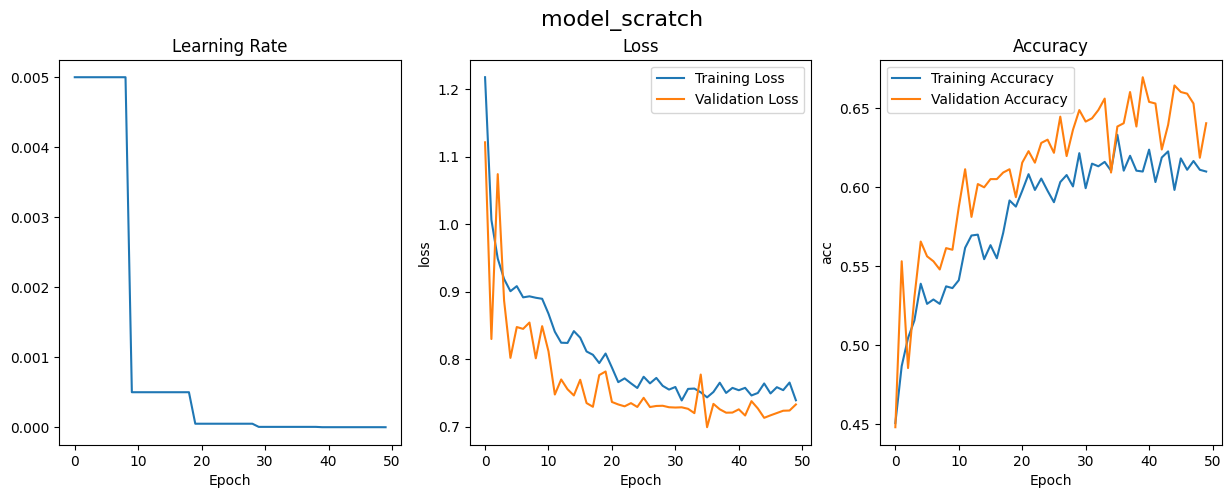

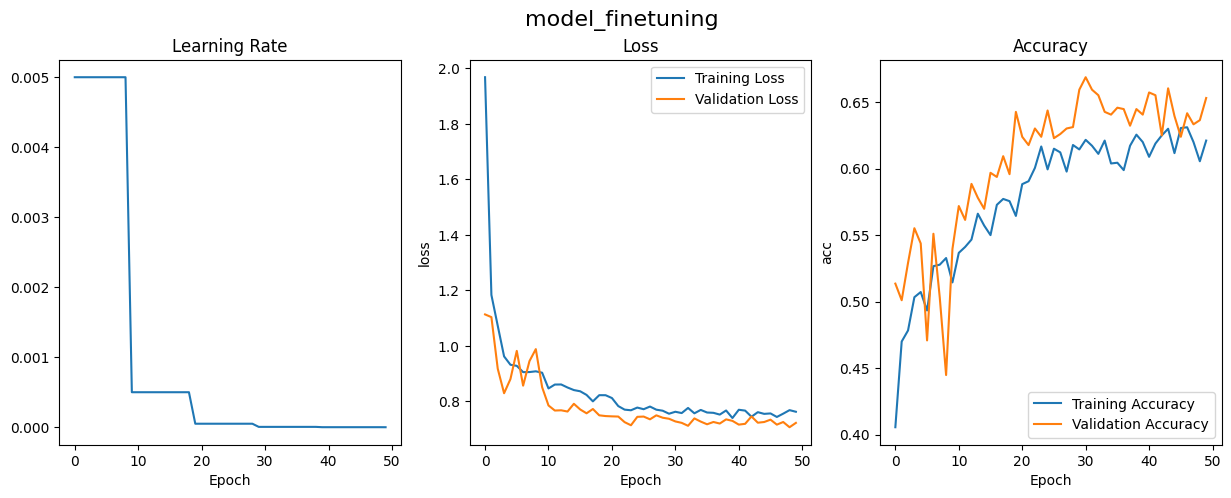

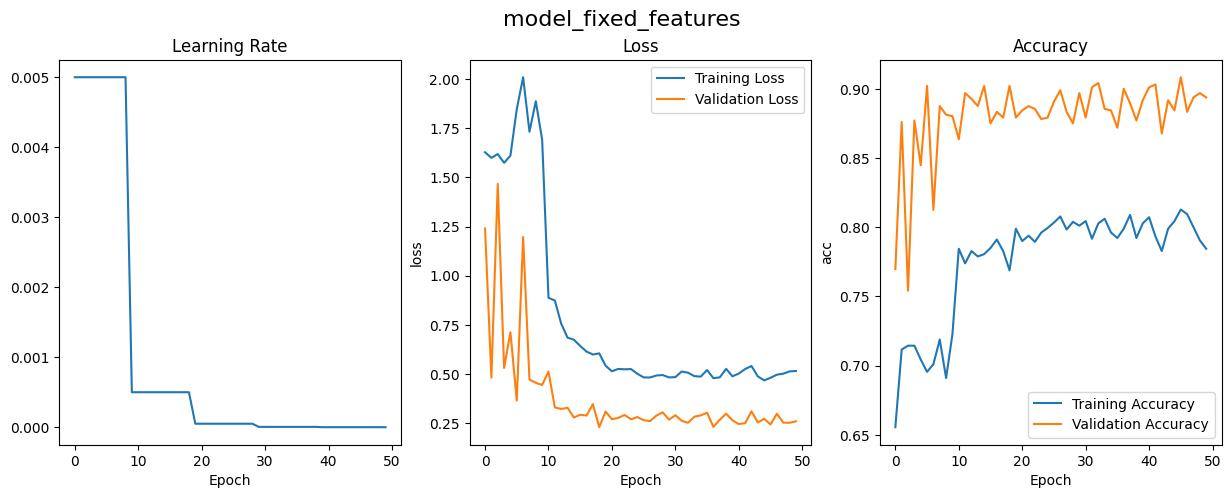

In [40]:
def plotting(input_metric, input_metric_name):
    
    
    fig, arg = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(input_metric_name, fontsize=16)
    # Plot for Learning Rate
    arg[0].plot(np.array(input_metric['learning_rate_history']), label='learning rate')
    arg[0].set_title('Learning Rate')
    arg[0].set_xlabel('Epoch')

    # Plot for loss
    arg[1].plot(np.array(input_metric['train_loss_history']), label='Training Loss')
    arg[1].plot(np.array(input_metric['valid_loss_history']), label='Validation Loss')
    arg[1].set_title('Loss')
    arg[1].set_xlabel('Epoch')
    arg[1].set_ylabel('loss')
    arg[1].legend()

    # Plot for accuracy
    arg[2].plot(np.array(input_metric['train_acc_history']), label='Training Accuracy')
    arg[2].plot(np.array(input_metric['valid_acc_history']), label='Validation Accuracy')
    arg[2].set_title('Accuracy')
    arg[2].set_xlabel('Epoch')
    arg[2].set_ylabel('acc')
    arg[2].legend()

    plt.show()
plotting(metric_scratch, 'model_scratch')
plotting(metric_finetuneing, 'model_finetuning')
plotting(metric_fixed_features, 'model_fixed_features')

#### Function of Testing

In [37]:
def load_model(model_path, model, device):
    """
    Load the trained model from a file.
    """
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model


def test_model(model_path, model, criterion, test_loader, device, show_images=False, images_per_figure=10):
    """
    Test the trained model with the provided test loader and optionally display images.
    """
    model = load_model(model_path, model, device)
    model.eval()  # Set model to evaluation mode
    
    test_loss = 0.0
    all_preds = []
    all_targets = []
    class_names = classes_names

    # Initialize for image display
    if show_images:
        fig, axes = None, None
        current_image_count = 0

    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)

            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            if show_images:
                # Prepare to display images
                if current_image_count % images_per_figure == 0:
                    if fig is not None:
                        plt.tight_layout()
                        plt.show()
                    # Calculate columns needed for the current set of images
                    num_images_remaining = len(test_loader.dataset) - current_image_count
                    cols = min(images_per_figure, num_images_remaining)
                    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(cols * 2, 2))  # Adjusted figsize
                    if cols == 1:
                        axes = [axes]  # Ensure axes is iterable
                    
                ax = axes[current_image_count % images_per_figure]

                image = data.cpu().data[0].permute(1, 2, 0).numpy()
                image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
                image = np.clip(image, 0, 1)
                ax.imshow(image)
                ax.set_title(f'Predicted: {class_names[preds[0]]}')
                ax.axis('off')
                current_image_count += 1

    if show_images and fig is not None:
        plt.tight_layout()
        plt.show()

    # Calculate average loss and accuracy
    test_loss /= len(test_loader.dataset)
    accuracy = np.mean(np.array(all_preds) == np.array(all_targets))

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    test_metrics = {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'confusion_matrix': cm
    }

    return test_metrics


In [38]:
# Testing
show_images = False
criterion = nn.CrossEntropyLoss()
scratch_metics = test_model('/home/hplab/melson/r12521715_HW4/model_scratch.pt', model_scratch, criterion, loaders_scratch['test'], device, show_images)
finetuning_metrics = test_model('/home/hplab/melson/r12521715_HW4/model_finetuning.pt', model_finetuning, criterion, loaders_scratch['test'], device, show_images)
fixedFeaturess_metrics = test_model('/home/hplab/melson/r12521715_HW4/model_fixed_features.pt', model_fixed_features, criterion, loaders_scratch['test'], device, show_images)

#### 2.5 Please calculate the confusion matrix and print the accuracy of three models with the test dataset. (10%)
##### (Example figure)
![](https://i.imgur.com/8U2vl7W.png)

In [39]:
def plot_confusion_matrix(model_metric, class_names, model_name):
    """
    Plot the confusion matrix using seaborn and matplotlib.
    """
    plt.figure(figsize=(5, 4))
    sns.heatmap(model_metric['confusion_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('From %s (Acc: %.4f%%)' % (model_name, model_metric['accuracy']*100))
    plt.show()

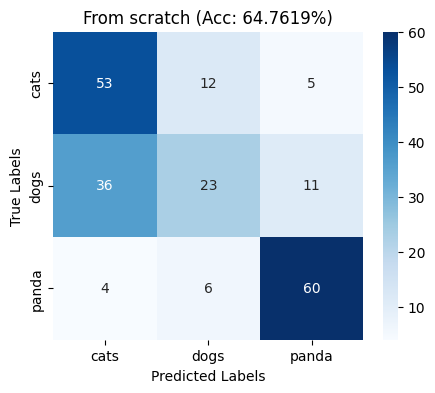

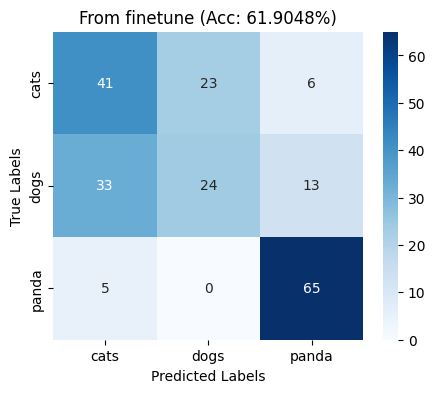

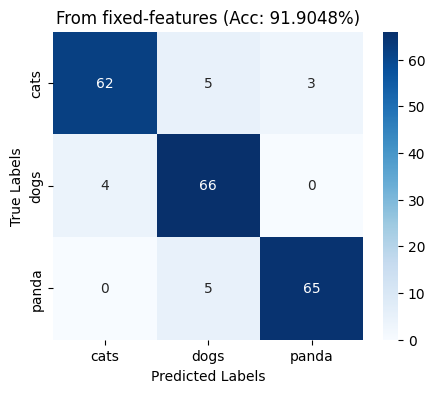

In [40]:
#plot confusion matrix
## scartch
plot_confusion_matrix(scratch_metics, classes_names, "scratch")
plot_confusion_matrix(finetuning_metrics, classes_names, "finetune")
plot_confusion_matrix(fixedFeaturess_metrics, classes_names, "fixed-features")

#### 2.6 Please choose the best model to predict the categories of images in the ***./animals/predict*** folder and show the figure with the prediction as title of each axes. (10%)
##### (Example figure)
![](https://i.imgur.com/Z5v7rET.jpg)

In [47]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class FlatFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        image = torch.unsqueeze(image, 0)  # Add a batch dimension
        return image
    
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [57]:
def predict_and_visualize(model_path, model, test_loader, device, show_images=False, images_per_figure=10):
    """
    Perform predictions using a trained model and optionally display images with their predicted labels.

    Args:
        model_path (str): Path to the trained model.
        model (torch.nn.Module): The model class instance.
        test_loader (torch.utils.data.DataLoader): DataLoader containing the test dataset.
        device (torch.device): Device to perform computations on.
        show_images (bool): Whether to display images alongside their predictions.
        images_per_figure (int): Number of images per figure when displaying.
    """
    # Load the model and switch to evaluation mode
    model = load_model(model_path, model, device)
    model.eval()

    class_names = ['cat', 'dog', 'panda']  # Placeholder class names, adjust if you know the actual classes

    if show_images:
        fig, axes = None, None
        current_image_count = 0

    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            
            # Forward pass to get outputs
            outputs = model(data)
            _, preds = torch.max(outputs, 1)

            # Image visualization block
            if show_images:
                if current_image_count % images_per_figure == 0:
                    if fig is not None:
                        plt.tight_layout()
                        plt.show()
                    num_images_remaining = len(test_loader.dataset) - current_image_count
                    cols = min(images_per_figure, num_images_remaining)
                    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(cols * 2, 2))
                    if cols == 1:
                        axes = [axes]

                ax = axes[current_image_count % images_per_figure]
                image = data.cpu().data[0].permute(1, 2, 0).numpy()
                image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
                image = np.clip(image, 0, 1)
                ax.imshow(image)
                ax.set_title(f'Predicted: {class_names[preds[0]]}')
                ax.axis('off')
                current_image_count += 1

    if show_images and fig is not None:
        plt.tight_layout()
        plt.show()



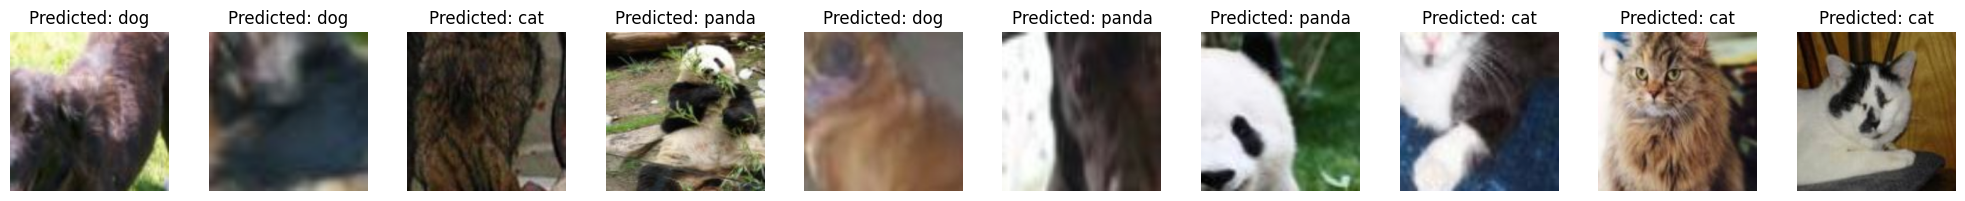

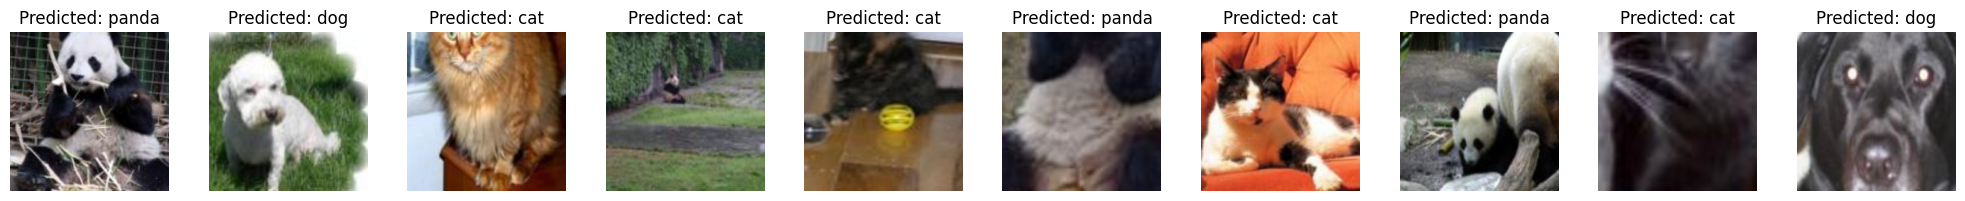

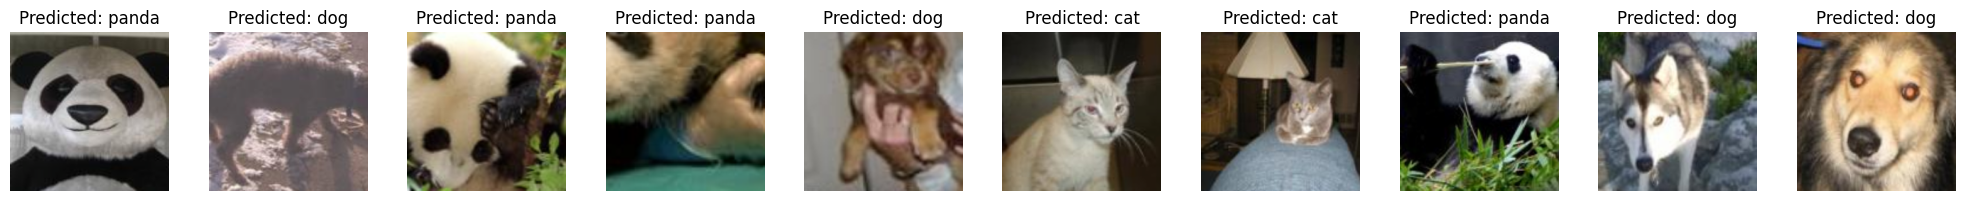

In [62]:

#load data
pred_datasets = FlatFolderDataset(root_dir = predictPath, transform = data_transforms_dict['prediction'])

#Dataloader
pred_loader = torch.utils.data.DataLoader(pred_datasets, batch_size=1, shuffle=False, num_workers=4)


# Testing
show_images = True
criterion = nn.CrossEntropyLoss()
predict_and_visualize('/home/hplab/melson/r12521715_HW4/model_fixed_features.pt', model_fixed_features, pred_loader, device, show_images)